In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

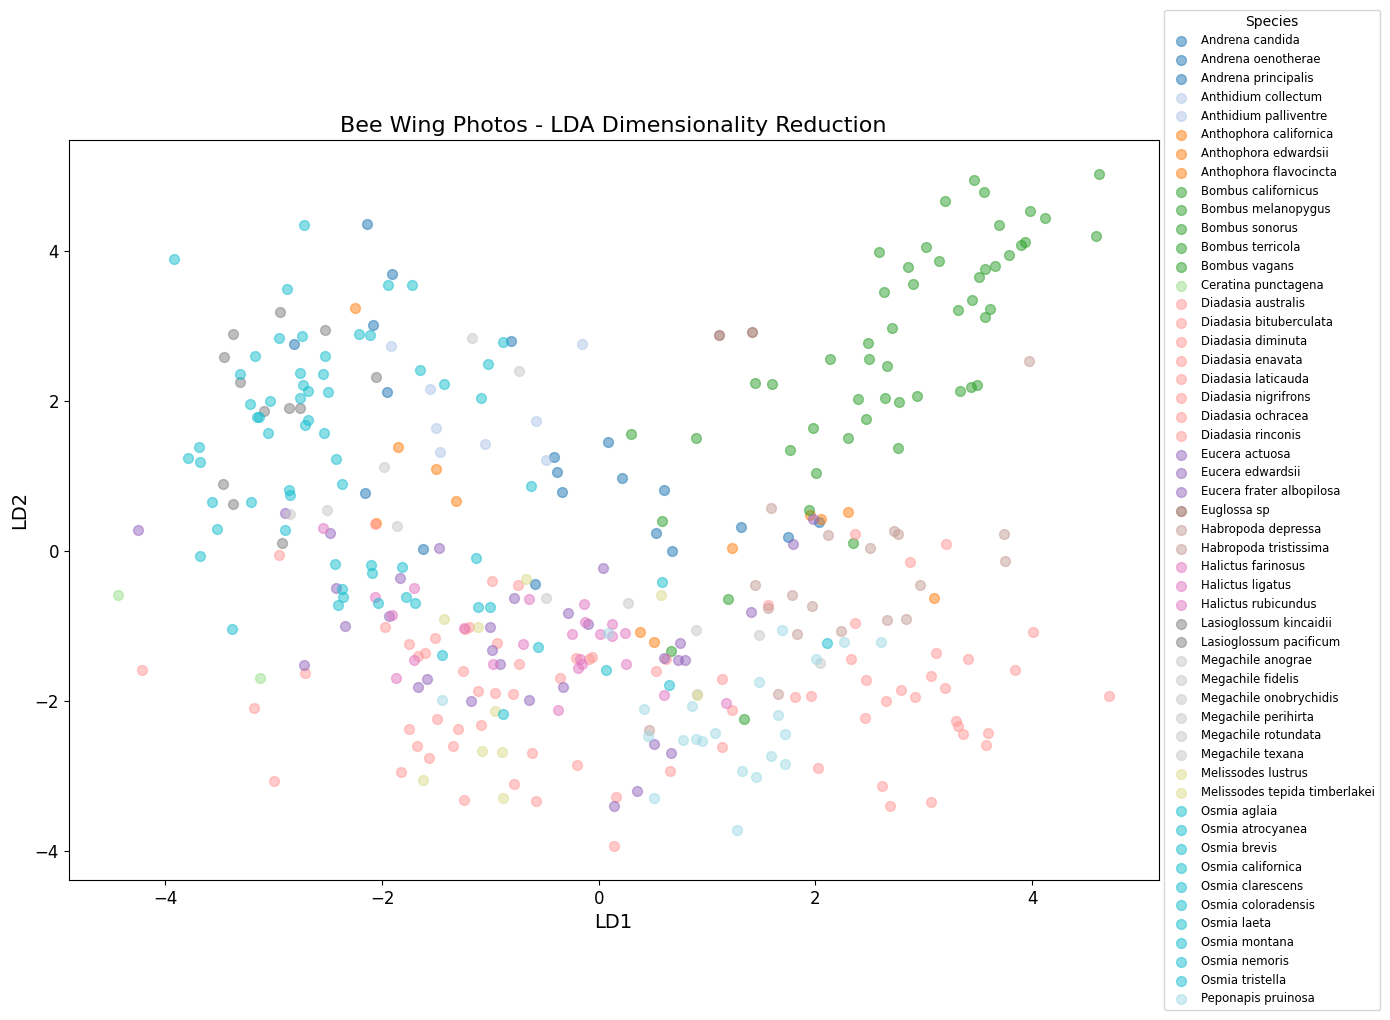

In [1]:

# Load the VGG16 network
base_model = VGG16(weights="imagenet", include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Define function to extract features from an image
def extract_features(image_path, model):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features
    except Exception as e:
        print(f"Failed to process image at {image_path}: {e}")
        return None


base_dir = 'C:/Users/moon/Desktop/capstone/Bee Wing Photos'

all_features = []
all_labels = []

for root, dirs, files in os.walk(base_dir):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            file_path = os.path.join(root, name)
            features = extract_features(file_path, model)
            if features is not None:
                all_features.append(features.flatten())
                all_labels.append(root.split(os.path.sep)[-1])  

# Convert lists to NumPy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Encode the labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(all_labels)

# Apply Linear Discriminant Analysis 
lda = LDA(n_components=2)
lda_features = lda.fit_transform(all_features, labels_encoded)

# Extract the genus from species name 
genus = [label.split()[0] for label in label_encoder.classes_]
unique_genus = np.unique(genus)
colors = plt.cm.get_cmap('tab20', len(unique_genus))

# Create a color dictionary for each genus
genus_to_color = {g: colors(i) for i, g in enumerate(unique_genus)}

# Visualize
plt.figure(figsize=(14, 10))
for i, label in enumerate(label_encoder.classes_):
    g = label.split()[0]
    mask = labels_encoded == i
    plt.scatter(lda_features[mask, 0], lda_features[mask, 1], label=label, color=genus_to_color[g], alpha=0.5, s=50)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title="Species")
plt.title('Bee Wing Photos - LDA Dimensionality Reduction', fontsize=16)
plt.xlabel('LD1', fontsize=14)
plt.ylabel('LD2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('LDA_Plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encoding the species labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(all_labels)

# Calculate centroids of each species in the LDA space
unique_labels = np.unique(labels_encoded)
centroids = {label_encoder.classes_[i]: np.mean(lda_features[labels_encoded == i], axis=0) for i in unique_labels}

# Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# EX) Calculate distance between 'Bombus sonorus' and 'Osmia laeta'
bombus_centroid = centroids['Bombus sonorus']
osmia_centroid = centroids['Osmia laeta']
distance = euclidean_distance(bombus_centroid, osmia_centroid)

print("Distance between Bombus sonorus and Osmia laeta:", distance)

# Max distance for percentage
max_distance = max([euclidean_distance(centroids[sp1], centroids[sp2]) for sp1 in centroids for sp2 in centroids if sp1 != sp2])

# EX) calculate the percentage difference for 'Bombus sonorus' and 'Osmia laeta'
percent_difference = (distance / max_distance) * 100

print(f"Percentage difference between Bombus sonorus and Osmia laeta: {percent_difference:.2f}%")



Distance between Bombus sonorus and Osmia laeta: 5.809262592629519
Percentage difference between Bombus sonorus and Osmia laeta: 67.36%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

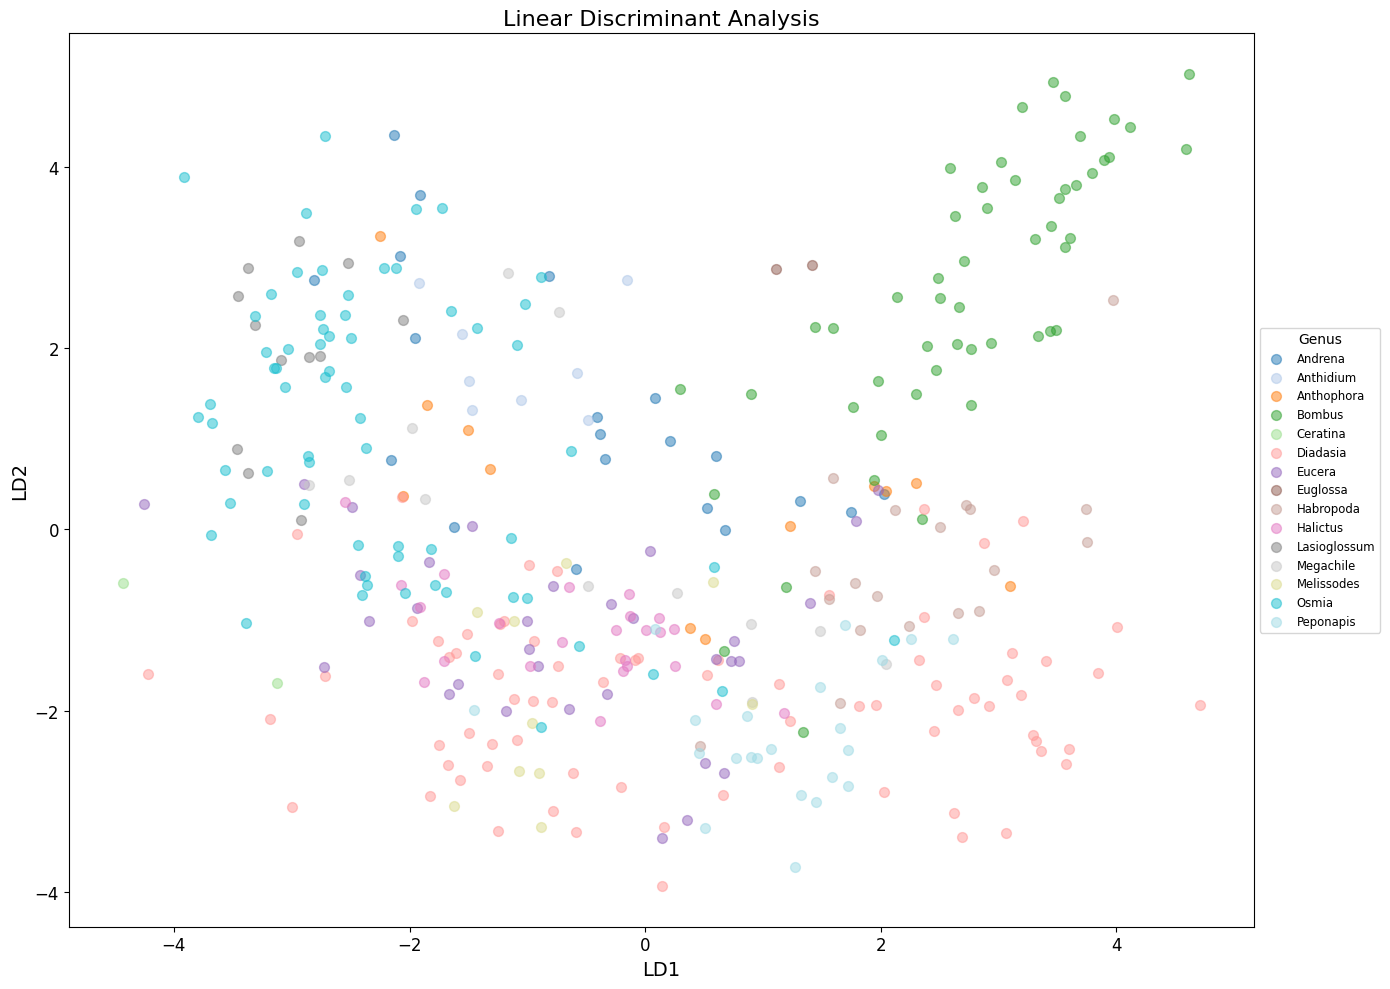

In [3]:


# Load the VGG16 network
base_model = VGG16(weights="imagenet", include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Define function to extract features from an image
def extract_features(image_path, model):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features
    except Exception as e:
        print(f"Failed to process image at {image_path}: {e}")
        return None

base_dir = 'C:/Users/moon/Desktop/capstone/Bee Wing Photos'

all_features = []
all_labels = []

# Walk through the image files
for root, dirs, files in os.walk(base_dir):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            file_path = os.path.join(root, name)
            features = extract_features(file_path, model)
            if features is not None:
                all_features.append(features.flatten())
                all_labels.append(root.split(os.path.sep)[-1])  

# Convert lists to NumPy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Encode the labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(all_labels)

# Apply Linear Discriminant Analysis 
lda = LDA(n_components=2)
lda_features = lda.fit_transform(all_features, labels_encoded)

# Extract the genus from species name 
genus = [label.split()[0] for label in all_labels]
unique_genus = np.unique(genus)
colors = plt.cm.get_cmap('tab20', len(unique_genus))

# Create a color dictionary for each genus
genus_to_color = {g: colors(i) for i, g in enumerate(unique_genus)}

# Visualize
plt.figure(figsize=(14, 10))
for g in unique_genus:
    genus_mask = np.array([label.split()[0] == g for label in all_labels])
    plt.scatter(lda_features[genus_mask, 0], lda_features[genus_mask, 1], label=g, color=genus_to_color[g], alpha=0.5, s=50)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title="Genus")
plt.title('Linear Discriminant Analysis', fontsize=16)
plt.xlabel('LD1', fontsize=14)
plt.ylabel('LD2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('LDA_Plot_Simplified.png', dpi=300, bbox_inches='tight')
plt.show()


### Summary of Bee Wing Morphology Analysis Using Linear Discriminant Analysis (LDA)

# Objective
The primary objective of this analysis was to explore the wing morphology differences among various bee species through the application of Linear Discriminant Analysis (LDA). This approach aimed at simplifying the complex, high-dimensional data obtained from the wing images into a more interpretable two-dimensional space.

# Methodology
1. Feature Extraction:
Utilized the pre-trained VGG16 model to extract features from images of bee wings. VGG16 was chosen to capture the intricate details in the bee wing images. 
2. Data Preparation:
Extracted features were flattened and paired with their corresponding species labels, which were derived from the directory structure of the images.
3. Dimensionality Reduction with LDA:
Applied LDA to reduce the dimensionality of the extracted features to two dimensions, aiming to preserve as much discriminatory information as possible.
The transformation was performed to maximize the separation between the classes (species) while minimizing the variance within each class.

# Visualization
The results of the LDA were visualized in a scatter plot, with each point representing an image labeled by its corresponding species. Colors were assigned based on the genus to which each species belongs, providing a visual distinction among genera. This visualization helped in assessing the effectiveness of the feature extraction and LDA in distinguishing between different species based on wing morphology.

# Quantitative Analysis
Calculated the centroids for each species in the reduced feature space as a mean of all points belonging to that species.
Measured Euclidean distances between centroids of selected species pairs to quantify the morphological differences.
Highlighted the maximum distance found among all pairs and used this to express distances as a percentage, offering a relative measure of difference.

# Conclusion
This analysis successfully demonstrated the use of a LDA in conjunction with deep learning feature extraction to study biological diversity. The clear separation of species in the LDA plot validates the hypothesis that wing morphology can serve as a reliable basis for species identification. 